# **If Monet and Cézanne Visited Yosemite**
------------------

------------------------------------------------------------------------------
**RUN THIS IN GOOGLE COLAB! **

This will run fastest using the GPU in google Colab. The datasets used are downloaded into the notebook in some of the first cells. All you need to do is run all cells. 
______________________________________________________________________________

This project is to generate images of Yosemite National Park in the painting style of Claud Monet and Paul Cézanne. The model doesn't produce an entirely new image, instead bases an already existing image of Yosemite, and produces one image in the style of Monet, and one image in the style of Cézanne. The datasets used are all datasets provided from Tensorflow. All three datasets are over 500 instances, and the Yosemite and Monet datasets are over 1000 instances. They are all .jpg images, 256x256 in size. 

The program uses a CycleGAN architecture to apply the Monet/Cézanne painting style to the Yosemite photos. To begin, split the datasets into a 10/90 test/training split. Go through all images in the training sets and randomly flip, crop and jitter them. Jittering the image just moves the image around a bit. Those processes are shown below with examples shown after. This editing helps the program better determine the underlying styles of the artists. 

CycleGAN uses an architecture of two Generators. This notebook uses 2 sepereate CycleGAN's, one per artist, for a total of 4 generators. For each CycleGAN, one generator produces a fake Yosemite photo, then the other generator takes that photo and tries to edit it back to the original real photo. For example, Generator G and Generator H exist, real photo X exists. G(X) = Y, then F(Y) ~= X. So F(G(X)) ~= X. These generators produce their photos for the discriminators to classify which photo is real, between the real image and the generated image. By the generators and discriminators working in competition to each other, they both improve in a zero-sum game. 

The generator is a modified U-Net architecture. I use the generator from Pix2Pix Github. Here is a photo of the architecture https://drive.google.com/file/d/1hxK0cQ7Rbf2wTJpYYQ6_MuPzvNuuHzDl/view?usp=sharing.

The discriminator is a PatchGAN Architecture. Also from Pix2Pix. Here is the architecture https://drive.google.com/file/d/1j0yPOECfQANUhh8tLGGhvW3EPPuU1uR2/view?usp=sharing.

The training generates an image, then runs it against the discriminator. Based off of those results, it produces the accuracy of the generator and discriminator and applies that loss to the gradients of the the generator and discriminator. I have it set to 10 epochs right now, but that is not enough. Currently, each epoch runs both CycleGAN's once, overall taking just about 8min/epoch using Google Colab GPU (I was told that TPU was faster than GPU but when I tested it once, it seemed to be slower. I will look into that). The predicted image is displayed after each epoch, so if you want to see an image, just run this notebook for ~8min to see the first image produced. The generators and discriminators are saved after 10 epochs. This is the same time as it took just to run CycleGAN, so there is not much added time to training a second CycleGAN for Cézanne's style. The longest I have run it for so far is about 10 epochs, but I plan to run it for 12 hours, hopefully getting 75 epochs in, so I can see the results.

I would like to see if I can reduce this time per epoch to make it faster at training. I might think about changing the crop of the image to 128x128 pixels, thinking that might make it faster to train. Obviously 256x256 is not HD, so I am not worrying about the resolution of the images produced. I might also go edit the generator and discriminator to see if I can sacrifice any amount of accuracy for speed. I also plan to add another CycleGAN to produce Van Gogh styled images.

If Professor Spector is grading this - I am currently in the works of scheduling a meeting to talk with you about the complicatedness of this project. I want to make sure that I am putting enough effort into this project. Depending on your thoughts, this project might change a good amount in one place or another of the code.

In [1]:
!pip install -q git+https://github.com/tensorflow/examples.git

In [2]:
import tensorflow as tf

In [3]:
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [4]:
dataset, metadata = tfds.load('cycle_gan/monet2photo',
                              with_info=True, as_supervised=True)

train_monet = dataset['trainA']
test_monet = dataset['testA']


dataset, metadata = tfds.load('cycle_gan/summer2winter_yosemite',
                              with_info=True, as_supervised=True)

train_summer = dataset['trainA']
test_summer = dataset['testA']

dataset, metadata = tfds.load('cycle_gan/cezanne2photo',
                              with_info=True, as_supervised=True)

train_cezanne = dataset['trainA']
test_cezanne = dataset['testA']

4
4
4


In [6]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [7]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [8]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [9]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [10]:
def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [11]:
def preprocess_image_test(image, label):
  image = normalize(image)
  return image

In [12]:
train_summer = train_summer.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

train_monet = train_monet.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

train_cezanne = train_cezanne.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_summer = test_summer.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_monet = test_monet.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_cezanne = test_cezanne.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

In [13]:
sample_summer = next(iter(train_summer))
sample_monet = next(iter(train_monet))
sample_cezanne = next(iter(train_cezanne))

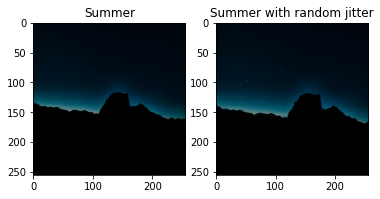

In [14]:
plt.subplot(121)
plt.title('Summer')
plt.imshow(sample_summer[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Summer with random jitter')
plt.imshow(random_jitter(sample_summer[0]) * 0.5 + 0.5)

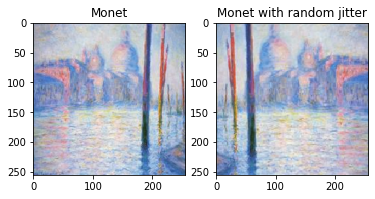

In [15]:
plt.subplot(121)
plt.title('Monet')
plt.imshow(sample_monet[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet with random jitter')
plt.imshow(random_jitter(sample_monet[0]) * 0.5 + 0.5)

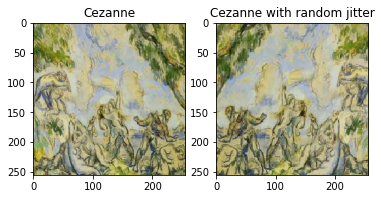

In [16]:
plt.subplot(121)
plt.title('Cezanne')
plt.imshow(sample_cezanne[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Cezanne with random jitter')
plt.imshow(random_jitter(sample_cezanne[0]) * 0.5 + 0.5)

## Import and reuse the Pix2Pix models

In [17]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_p = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_q = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')


discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_a = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_b = pix2pix.discriminator(norm_type='instancenorm', target=False)

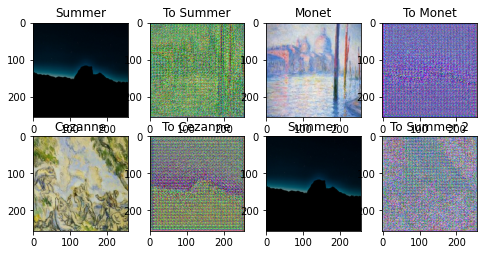

In [18]:
to_monet = generator_g(sample_summer)
to_summer = generator_f(sample_monet)
to_cezanne = generator_p(sample_summer)
to_summer_2 = generator_q(sample_cezanne)

plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_summer, to_summer, sample_monet, to_monet, sample_cezanne, to_cezanne, sample_summer, to_summer_2]
title = ['Summer', 'To Summer', 'Monet', 'To Monet', 'Cezanne', 'To Cezanne', 'Summer', 'To Summer 2']

for i in range(len(imgs)):
  plt.subplot(4, 4, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

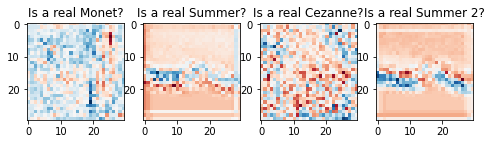

In [19]:
plt.figure(figsize=(8, 8))

plt.subplot(141)
plt.title('Is a real Monet?')
plt.imshow(discriminator_y(sample_monet)[0, ..., -1], cmap='RdBu_r')

plt.subplot(142)
plt.title('Is a real Summer?')
plt.imshow(discriminator_x(sample_summer)[0, ..., -1], cmap='RdBu_r')

plt.subplot(143)
plt.title('Is a real Cezanne?')
plt.imshow(discriminator_a(sample_cezanne)[0, ..., -1], cmap='RdBu_r')

plt.subplot(144)
plt.title('Is a real Summer 2?')
plt.imshow(discriminator_b(sample_summer)[0, ..., -1], cmap='RdBu_r')

plt.show()

## Loss functions

In [20]:
LAMBDA = 10

In [21]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [22]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [23]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [24]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
  return LAMBDA * loss1

In [25]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

Initialize the optimizers for all the generators and the discriminators.

In [26]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_p_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_q_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_a_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_b_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Checkpoints

In [27]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           generator_p=generator_p,
                           generator_q=generator_q,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           discriminator_a=discriminator_a,
                           discriminator_b=discriminator_b,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           generator_p_optimizer=generator_p_optimizer,
                           generator_q_optimizer=generator_q_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer,
                           discriminator_a_optimizer=discriminator_a_optimizer,
                           discriminator_b_optimizer=discriminator_b_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [28]:
EPOCHS = 10

In [29]:
def generate_images(model, test_input, style):
  prediction = model(test_input)
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  if style == 'monet':
    title = ['Input Image', 'Predicted Monet Image']
  else:
    title = ['Input Image', 'Predicted Cezanne Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [30]:
@tf.function
def train_step_monet(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

In [31]:
@tf.function
def train_step_cezanne(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator P translates X -> Y
    # Generator Q translates Y -> X.
    
    fake_y = generator_p(real_x, training=True)
    cycled_x = generator_q(fake_y, training=True)

    fake_x = generator_q(real_y, training=True)
    cycled_y = generator_p(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_q(real_x, training=True)
    same_y = generator_p(real_y, training=True)

    disc_real_x = discriminator_a(real_x, training=True)
    disc_real_y = discriminator_b(real_y, training=True)

    disc_fake_x = discriminator_a(fake_x, training=True)
    disc_fake_y = discriminator_b(fake_y, training=True)

    # calculate the loss
    gen_p_loss = generator_loss(disc_fake_y)
    gen_q_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    # Total generator loss = adversarial loss + cycle loss
    total_gen_p_loss = gen_p_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_q_loss = gen_q_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_a_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_b_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
  # Calculate the gradients for generator and discriminator
  generator_p_gradients = tape.gradient(total_gen_p_loss, 
                                        generator_p.trainable_variables)
  generator_q_gradients = tape.gradient(total_gen_q_loss, 
                                        generator_q.trainable_variables)
  
  discriminator_a_gradients = tape.gradient(disc_a_loss, 
                                            discriminator_a.trainable_variables)
  discriminator_b_gradients = tape.gradient(disc_b_loss, 
                                            discriminator_b.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_p_optimizer.apply_gradients(zip(generator_p_gradients, 
                                            generator_p.trainable_variables))

  generator_q_optimizer.apply_gradients(zip(generator_q_gradients, 
                                            generator_q.trainable_variables))
  
  discriminator_a_optimizer.apply_gradients(zip(discriminator_a_gradients,
                                                discriminator_a.trainable_variables))
  
  discriminator_b_optimizer.apply_gradients(zip(discriminator_b_gradients,
                                                discriminator_b.trainable_variables))

G=P
F=Q

X=A
Y=B

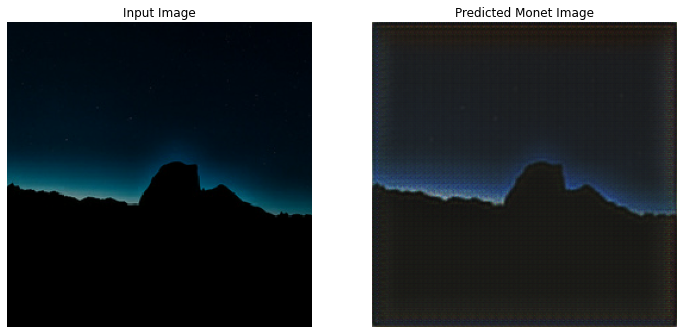

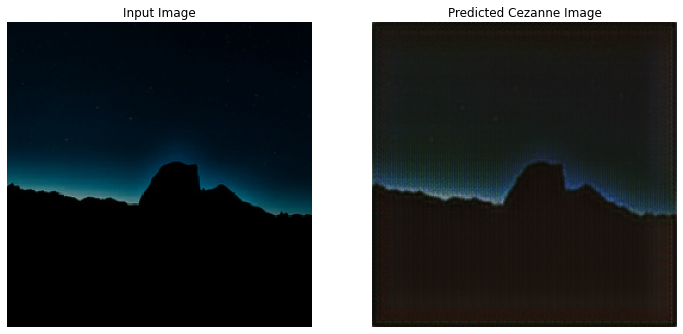

Time taken for epoch 1 is 494.96723079681396 sec

.............

KeyboardInterrupt: ignored

In [32]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y, image_z in tf.data.Dataset.zip((train_summer, train_monet, train_cezanne)):
    train_step_monet(image_x, image_y)
    train_step_cezanne(image_x, image_z)
    if n % 10 == 0:
      print ('.', end='')
    n+=1

  clear_output(wait=True)
  # Using a consistent image (sample_summer) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_summer, 'monet')
  generate_images(generator_p, sample_summer, 'cezanne')

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

In [ ]:
# Run the trained model on the test dataset
for inp in test_summer.take(5):
  generate_images(generator_g, inp)